This version implements these changes:
- removal of normal tissue
- individual cox ph analysis, ranking with adjusted p-values
- then, a cox ph analysis with all genes

Load data!
1. geneData: gene expression data
2. phenotypes: other data about the samples
3. survivalData: rates, times, etc. related to survival

In [5]:
# phenotype data to get sample_type
import pandas as pd

geneData = pd.read_csv("TCGA.STAD.sampleMap_HiSeqV2_PANCAN.tsv", sep='\t', low_memory=False, index_col=0, header=None)
geneData = geneData.transpose() # list samples horizontally

phenotypes = pd.read_csv("TCGA.STAD.sampleMap_STAD_clinicalMatrix.tsv", sep='\t')
phenotypes.rename(columns={"sampleID": "sample"}, inplace=True) # match sample labels' column name

survivalData = pd.read_csv("Survival Data - Stomach Cancer.csv", low_memory=False, index_col=0)

# COMBINED DATA
df = pd.merge(geneData, phenotypes, on='sample', how='inner')
df = pd.merge(df, survivalData, on='sample', how='inner')

df = df[df['sample_type'] == 'Primary Tumor']

In [6]:
df

,sample,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,...,_PATIENT_y,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,TCGA-FP-A4BE-01,1.22480753024,-1.74772633632,-0.531035005853,-0.257771985954,0.019121865002,-0.376309910261,-0.627894490831,0.0507543425673,-0.423399406945,...,TCGA-FP-A4BE,0,337.0,0.0,337.0,0.0,337.0,0,337.0,NaN
1,TCGA-BR-8081-01,0.614507530238,-0.110026336325,-0.531035005853,0.026728014046,-0.550378134998,-0.398609910261,-0.846094490831,1.18205434257,0.615700593055,...,TCGA-BR-8081,0,981.0,0.0,981.0,0.0,981.0,0,981.0,NaN
3,TCGA-IN-7806-01,2.24880753024,4.36007366368,-0.531035005853,0.252328014046,-0.463778134998,-0.768109910261,-0.311694490831,0.710954342567,-0.423399406945,...,TCGA-IN-7806,0,1106.0,0.0,1106.0,0.0,1106.0,0,1106.0,NaN
4,TCGA-BR-4257-01,-0.589492469762,-3.20082633632,-0.531035005853,-0.484871985954,-0.431178134998,0.425990089739,-0.364494490831,-0.891645657433,1.09720059306,...,TCGA-BR-4257,1,294.0,NaN,294.0,NaN,NaN,0,294.0,NaN
5,TCGA-RD-A8N6-01,1.74420753024,6.34547366368,-0.531035005853,-0.058471985954,-0.000678134998031,0.00489008973857,0.246705509169,1.30825434257,-0.423399406945,...,TCGA-RD-A8N6,1,272.0,1.0,272.0,1.0,163.0,1,163.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,TCGA-BR-8690-01,0.287607530238,2.09637366368,-0.531035005853,0.061828014046,-0.151778134998,-0.617709910261,0.024405509169,2.08385434257,-0.423399406945,...,TCGA-BR-8690,0,325.0,0.0,325.0,0.0,325.0,0,325.0,NaN
446,TCGA-VQ-A8DV-01,-0.354192469762,4.68107366368,-0.531035005853,-0.255271985954,-0.204978134998,-0.573209910261,0.819105509169,-0.657845657433,0.379300593055,...,TCGA-VQ-A8DV,1,403.0,1.0,403.0,NaN,NaN,1,288.0,NaN
447,TCGA-D7-6527-01,-0.607492469762,-0.642026336325,-0.531035005853,0.294828014046,-0.691078134998,-0.382009910261,0.580305509169,1.55565434257,-0.423399406945,...,TCGA-D7-6527,1,312.0,1.0,312.0,NaN,NaN,1,75.0,NaN
448,TCGA-BR-A4PD-01,-1.01009246976,-1.11912633632,-0.531035005853,0.080528014046,0.027221865002,0.0170900897386,-0.021194490831,2.03905434257,0.732700593055,...,TCGA-BR-A4PD,0,628.0,0.0,628.0,0.0,628.0,0,628.0,NaN


1. Categorize indiviuals based on gene expression
* Break into two groups based on a threshold (median)
* Sometimes, there will be cases where the entire gene falls at/above the median and therefore it won't split neatly into two.
    * Considered breaking by mean, but that could lead to uneven splits between groups or affected by outliers more.
    * Solution: currently, to skip genes where it can't split into two equal groups

In [3]:
# RETURNS MODIFIED, COPIED DATA: create a new column with threshold assigned to each sample/row, based on a gene's expression
def breakdown(gene):
    df_copy = df.copy()
    df_copy[gene] = pd.to_numeric(df_copy[gene], errors='coerce')
    df_copy = df_copy.dropna(subset=[gene], how='any')
    
    median = df_copy[gene].median()

    def categorize(val):
        return 0 if val < median else 1

    df_copy['threshold'] = df_copy[gene].apply(categorize)
    
    return df_copy

** THIS CODE TOOK AN HOUR TO RUN, WOULDN'T RECOMMEND DOING IT AGAIN **
2. Using those two groups, calculate statistical significance on each gene. Rank, then choose the most statistically significant genes to examine further.

The *breakdown* function is called within the kaplan_meier_stat_sig function to separate the data into two groups for each gene.

In [4]:
stats = {"gene": [], "significance (p-values)": []}
df_stats = pd.DataFrame(stats)

In [13]:
from lifelines.statistics import logrank_test

# Calculates statistical significance of each pair of Kaplan-Meier curves.

def kaplan_meier_stat_sig(gene):
    gene_df = breakdown(gene)
    
    dfA = gene_df[gene_df['threshold'] == 0]
    dfB = gene_df[gene_df['threshold'] == 1]
    
    durations_A = dfA['DSS.time']
    durations_B = dfB['DSS.time']
    events_A = dfA['DSS']
    events_B = dfB['DSS']
    
    if df[gene].hasnans:
        print(gene + " skipped due to containing NA values")
        return
    elif abs(durations_A.size - durations_B.size) > 10:
        # indicate that no p value can be calculated, uneven group size/one group does not exist
        print(gene + " skipped due to uneven group size (sizes " + str(durations_A.size) + " and " + str(durations_B.size) + ")")
        return
    elif durations_A.size + durations_B.size < 200:
        # if more than half of the dataset is not available for this gene
        print(gene + " skipped due to not enough data (total of " + str(durations_A.size + durations_B.size) + " samples)")
        return
    
    results = logrank_test(durations_A, durations_B, event_observed_A=events_A, event_observed_B=events_B, t_0=-1)
    add = {'gene': gene, 'significance (p-values)': results.p_value}
    df_stats.loc[len(df_stats)] = add

In [14]:
# Kaplan-Meier + p-val logrank for each curve - THIS IS THE CODE THAT TAKES FOREVER BE CAREFUL
    # 20531 columns of gene expression data, including sampleID
for i in range(1, 20531):
    if i % 1000 == 0:
        print("\n")
        print(str((i/20531) * 100) + "% done")
        print("\n")
    gene = df.columns[i]
    kaplan_meier_stat_sig(gene)

RNF17 skipped due to uneven group size (sizes 0 and 415)
C16orf11 skipped due to uneven group size (sizes 0 and 415)
LOC339240 skipped due to uneven group size (sizes 0 and 415)
RBMY1A3P skipped due to uneven group size (sizes 0 and 415)
LRRTM3 skipped due to uneven group size (sizes 0 and 415)
OVCH1 skipped due to uneven group size (sizes 0 and 415)
TRHR skipped due to uneven group size (sizes 0 and 415)
OR8J1 skipped due to uneven group size (sizes 0 and 415)
SNORD115-17 skipped due to uneven group size (sizes 0 and 415)
LOC286359 skipped due to uneven group size (sizes 0 and 415)
TMPRSS11B skipped due to uneven group size (sizes 0 and 415)
TMPRSS11F skipped due to uneven group size (sizes 0 and 415)
RAD21L1 skipped due to uneven group size (sizes 0 and 415)
SLC36A3 skipped due to uneven group size (sizes 0 and 415)
HRH3 skipped due to uneven group size (sizes 0 and 415)
TMEM212 skipped due to uneven group size (sizes 0 and 415)
SNORD115-13 skipped due to uneven group size (sizes 0 a

In [15]:
df_stats = df_stats.sort_values(by='significance (p-values)')

done = (len(df_stats) / 20531) * 100
print(str(100-done) + "% of genes skipped due to conditions")
print(str(len(df_stats)) + " genes included in analysis")

df_stats

12.23515659246992% of genes skipped due to conditions
18019 genes included in analysis


,gene,significance (p-values)
10824,PPP1R3B,1.863509e-07
10806,PRTG,1.287866e-06
10221,ZNF883,6.066378e-06
1955,NMNAT1,9.216836e-06
11870,PCDHA11,2.018575e-05
...,...,...
11648,CAMK2N2,9.994676e-01
6582,MLH3,9.994931e-01
6463,LFNG,9.995274e-01
9957,KLHL6,9.995971e-01


3. Let's look deeper into the statistically significant genes! -> graph the Kaplan-Meier survival curves
* x-axis: time in days
* y-axis: probability of survival

An example gene is shown below.

In [66]:
from lifelines import KaplanMeierFitter

def kaplan_meier_graph(gene):
    df = breakdown(gene)
    df = df.dropna(subset=['DSS', 'DSS.time'])
    
    df_below = df.loc[df['threshold'] == 0]
    df_above = df.loc[df['threshold'] == 1]
    
    kmf = KaplanMeierFitter()
    
    kmf.fit(df_below['DSS.time'], df_below['DSS'], label="Below threshold")
    ax = kmf.plot_survival_function()
    
    kmf.fit(df_above['DSS.time'], df_above['DSS'], label="At or above threshold")
    kmf.plot_survival_function(ax = ax)
    
    ax.set_title(gene + " Kaplan-Meier, split by levels of gene expression")

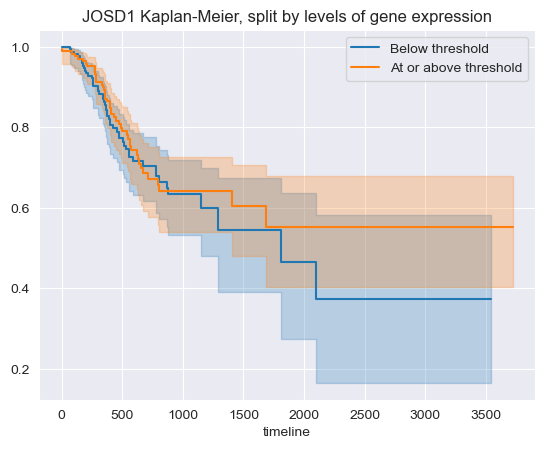

In [67]:
kaplan_meier_graph("JOSD1")

4. Multiple Test Corrections
* Given the very large dataset, we want to keep the error rate to <= the p-value cutoff; to avoid the many chances of a false positive.
* *What are we using to correct?* this code uses the 'standard' method of Benjamini/Hochberg
* https://www.graphpad.com/guides/prism/latest/statistics/stat_pros_and_cons_of_the_three_met.htm

In [16]:
from scipy.stats import false_discovery_control
df_stats['significance (p-values)'].dropna()
df_stats['BH corrected_significance'] = false_discovery_control(df_stats['significance (p-values)'], axis=0, method='bh')

In [4]:
import pandas as pd
df_stats = pd.read_csv("results_v2.csv")
adjusted_rank = df_stats.sort_values(by='BH corrected_significance', ascending=True)
adjusted_rank.head(15)

,gene,significance (p-values),BH corrected_significance
0,PPP1R3B,1.863509e-07,0.003358
1,PRTG,1.287866e-06,0.011603
2,ZNF883,6.066378e-06,0.036437
3,NMNAT1,9.216836e-06,0.041520
4,PCDHA11,2.018575e-05,0.072309
5,AKR1B1,2.944222e-05,0.072309
6,LOC113230,3.172154e-05,0.072309
7,MPND,3.543367e-05,0.072309
8,EIF4G2,3.611637e-05,0.072309
12,CST6,6.654618e-05,0.092238


In [18]:
df_stats.to_csv('results_v2.csv', index=False)

5. Cox Proportional Hazards Model - INDIVIDUALLY COMPUTED

*What does it do?* The Cox Proportional Hazards model is a model for survival analysis that allows us to take multiple covariates, or predictors, into account when predicting survival outcome.

We are going to do a second iteration where we do the Cox PH on each gene individually, then do adjusted p-values, then rank, similar to previous survival analysis with logrank test.

In [70]:
# reimport
df_stats = pd.read_csv('results_v2.csv')
df_stats

,Unnamed: 0.1,Unnamed: 0,gene,significance (p-values),BH corrected_significance
0,0,10773,PPP1R3B,0.000008,0.138457
1,1,13589,CTBP2,0.000032,0.211176
2,2,14962,JAKMIP1,0.000061,0.211176
3,3,1773,MARCKS,0.000071,0.211176
4,4,1473,LRRC45,0.000071,0.211176
...,...,...,...,...,...
17965,17965,8887,TBX6,0.999801,0.999982
17966,17966,9702,PRDM1,0.999852,0.999982
17967,17967,15496,OLFM2,0.999938,0.999982
17968,17968,3135,HNRNPA3P1,0.999969,0.999982


In [19]:
from lifelines import CoxPHFitter

df_stats['CPH indiv significance'] = None

def individual_coxph(m_gene):
    cph_data = df[[m_gene, 'DSS.time', 'DSS']].copy()
    cph_data.dropna(how='any', inplace=True)
    
    cph = CoxPHFitter()
    cph.fit(cph_data, duration_col='DSS.time', event_col='DSS')
    
    p_value = cph.summary.loc[m_gene, 'p'] 
    df_stats.loc[df_stats['gene'] == m_gene, 'CPH indiv significance'] = p_value

*Why only use genes from df_stats?* There will be a ConvergenceWarning on genes with low variance, which are the ones that df_stats skipped - all the median values are equal so there is no analysis possible to perform. These are considered redundant columns by the Cox PH function, and therefore should be skipped.

In [43]:
df_stats = pd.read_csv("results_v2.csv")
df_stats

,gene,significance (p-values),BH corrected_significance
0,PPP1R3B,1.863509e-07,0.003358
1,PRTG,1.287866e-06,0.011603
2,ZNF883,6.066378e-06,0.036437
3,NMNAT1,9.216836e-06,0.041520
4,PCDHA11,2.018575e-05,0.072309
...,...,...,...
18014,CAMK2N2,9.994676e-01,0.999638
18015,MLH3,9.994931e-01,0.999638
18016,LFNG,9.995274e-01,0.999638
18017,KLHL6,9.995971e-01,0.999653


In [44]:
for i in range(len(df_stats)):
    g = df_stats['gene'][i]
    individual_coxph(g)

In [45]:
df_stats.sort_values(by='CPH indiv significance', ascending=True, inplace=True)
df_stats

,gene,significance (p-values),BH corrected_significance,CPH indiv significance
551,TF,0.009521,0.310359,4.435064e-08
594,GAMT,0.010273,0.311108,4.618350e-07
1,PRTG,0.000001,0.011603,6.567848e-07
15,CGB5,0.000096,0.108192,1.191992e-06
99,SLC7A2,0.001013,0.179540,1.457352e-06
...,...,...,...,...
11399,TMEM111,0.534081,0.844176,9.995663e-01
6182,INPP5E,0.229642,0.669160,9.996430e-01
8030,SNORA63,0.329674,0.739406,1.000000e+00
2669,NOS1AP,0.070804,0.477786,1.000000e+00


In [48]:
df_stats.to_csv('results_v2_cph.csv', index=False)

In [49]:
# multiple test corrections on CPH
from scipy.stats import false_discovery_control

df_stats_v2 = df_stats[df_stats['CPH indiv significance'] != 0.0]
print(str(len(df_stats) - len(df_stats_v2)) + " values removed due to invalid/NA CPH values")

df_stats_v2['CPH corrected_significance'] = false_discovery_control(df_stats['CPH indiv significance'], axis=0,
                                                                method='bh')
adjusted_rank = df_stats_v2.sort_values(by='CPH corrected_significance', ascending=True)
adjusted_rank.head(10)

0 values removed due to invalid/NA CPH values


,gene,significance (p-values),BH corrected_significance,CPH indiv significance,CPH corrected_significance
551,TF,9.521162e-03,0.310359,4.435064e-08,0.000799
594,GAMT,1.027301e-02,0.311108,4.618350e-07,0.003945
1,PRTG,1.287866e-06,0.011603,6.567848e-07,0.003945
15,CGB5,9.606925e-05,0.108192,1.191992e-06,0.005252
99,SLC7A2,1.013368e-03,0.179540,1.457352e-06,0.005252
194,GOLGA9P,2.466224e-03,0.227892,2.968939e-06,0.008916
1157,PCDHB5,2.308397e-02,0.358995,4.091884e-06,0.010332
260,FLJ16779,3.618888e-03,0.247517,4.587298e-06,0.010332
22,ERBB4,1.596529e-04,0.125078,5.398123e-06,0.010808
0,PPP1R3B,1.863509e-07,0.003358,7.696304e-06,0.013811


In [50]:
adjusted_rank.to_csv("results_v2_cph.csv", index=False)

6. Cox PH model for ALL GENES
Looking at all p values for genes when performing this analysis on all genes at once, ranking based on that

In [51]:
df_stats_combined = pd.read_csv("results_v2_cph.csv")
df_stats_combined

,gene,significance (p-values),BH corrected_significance,CPH indiv significance,CPH corrected_significance
0,TF,0.009521,0.310359,4.435064e-08,0.000799
1,GAMT,0.010273,0.311108,4.618350e-07,0.003945
2,PRTG,0.000001,0.011603,6.567848e-07,0.003945
3,CGB5,0.000096,0.108192,1.191992e-06,0.005252
4,SLC7A2,0.001013,0.179540,1.457352e-06,0.005252
...,...,...,...,...,...
18014,GPR157,0.146129,0.581130,9.995324e-01,0.999788
18015,INPP5E,0.229642,0.669160,9.996430e-01,0.999809
18016,NOS1AP,0.070804,0.477786,1.000000e+00,1.000000
18017,SNORA63,0.329674,0.739406,1.000000e+00,1.000000


In [52]:
# SELECT genes to avoid convergence warning.
# we want genes that don't have low variance, let's choose most significant genes

cph_significant = df_stats_combined[df_stats_combined['CPH corrected_significance'] < 0.05]
genes_to_extract = cph_significant['gene'].tolist()
cph_data = df[genes_to_extract + ['DSS.time', 'DSS']].copy()
cph_data.dropna(how='any', inplace=True)

cph_data

,TF,GAMT,PRTG,CGB5,SLC7A2,GOLGA9P,PCDHB5,FLJ16779,ERBB4,PPP1R3B,...,C1orf173,TSKS,KIAA1239,TSKS,NAT8L,RBMS1,GPR133,TSKS,DSS.time,DSS
0,-5.34249230589,-3.47847777604,-1.84806211471,-0.846114170893,-3.75142205228,-1.03232899727,-3.77027314865,-2.16165445181,-4.43681634803,0.239265228248,...,-2.30921714397,-0.579387155677,3.68524024971,-0.579387155677,-4.0154144284,-1.35320692158,-1.86678885681,-0.579387155677,337.0,0.0
1,-0.798792305892,-1.97227777604,-0.264462114709,-0.411314170893,-1.16052205228,-1.03232899727,-0.937373148654,-1.96635445181,-2.82211634803,-0.969634771752,...,-0.455017143972,0.912512844323,3.19324024971,0.912512844323,-0.0689144284042,-0.473806921576,1.74621114319,0.912512844323,981.0,0.0
3,-1.96089230589,-3.29467777604,-1.01866211471,0.387785829107,-1.21752205228,-0.612228997269,-1.70217314865,-2.85835445181,-2.51511634803,0.232165228248,...,-0.0872171439719,-1.56558715568,3.13804024971,-1.56558715568,-3.5740144284,-1.67150692158,1.51771114319,-1.56558715568,1106.0,0.0
5,4.15690769411,-0.834877776044,1.82323788529,3.19098582911,2.19997794772,-0.670028997269,3.57932685135,0.458545548186,-0.28551634803,2.06616522825,...,1.14218285603,0.270112844323,1.72754024971,0.270112844323,2.0892855716,1.00099307842,3.92631114319,0.270112844323,272.0,1.0
6,-4.31489230589,1.85102222396,0.472837885291,0.549285829107,-0.0269220522825,-0.172128997269,-1.16637314865,-2.45085445181,-0.0376163480296,1.45146522825,...,-0.649417143972,-0.413087155677,2.42504024971,-0.413087155677,-1.0311144284,0.490093078424,1.38111114319,-0.413087155677,554.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,-5.91819230589,-1.00427777604,1.66523788529,0.674485829107,-1.04872205228,1.69177100273,0.175926851346,5.19704554819,0.70588365197,0.437065228248,...,0.505882856028,-1.56558715568,-1.65385975029,-1.56558715568,-1.9181144284,1.56479307842,0.000211143191613,-1.56558715568,325.0,0.0
446,9.23990769411,3.25352222396,3.11763788529,2.92518582911,2.43787794772,4.18117100273,0.587426851346,4.25774554819,2.21618365197,0.539965228248,...,-2.64821714397,0.555312844323,0.796740249707,0.555312844323,2.0306855716,1.13679307842,3.82691114319,0.555312844323,403.0,1.0
447,-4.17469230589,2.67772222396,1.09683788529,-0.290614170893,-0.543222052283,-1.03232899727,-1.04087314865,-1.50305445181,-3.79761634803,1.10656522825,...,4.19798285603,-1.56558715568,-0.698259750293,-1.56558715568,-2.2712144284,-1.35980692158,0.510911143192,-1.56558715568,312.0,1.0
448,1.27610769411,0.742622223956,-1.55956211471,1.59288582911,-1.28262205228,-1.03232899727,-2.02677314865,-3.60335445181,-3.44621634803,-0.0315347717519,...,4.34208285603,-1.56558715568,4.85674024971,-1.56558715568,-0.937614428404,0.121093078424,-3.40558885681,-1.56558715568,628.0,0.0


In [53]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.01)
cph.fit(cph_data, duration_col='DSS.time', event_col='DSS')

summary = cph.summary
p_values = summary['p'].to_dict() 

df_combined_cph = pd.DataFrame(list(p_values.items()), columns=['Feature', 'p_value'])
df_combined_cph.sort_values(by='p_value', ascending=True, inplace=True)
df_combined_cph.head(20)

,Feature,p_value
213,MYB,0.004965
116,ZNF883,0.006703
124,NRG2,0.010160
105,ZNF474,0.011911
127,GPR81,0.039599
16,GPR87,0.041353
17,APOD,0.048743
137,MEIS3P1,0.049645
209,FBXL2,0.053025
215,PKD1L2,0.058178


base model w/phenotypes only

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
family_history_of_stomach_cancer    -0.070071   0.932328  0.534529   
initial_weight                      -0.000456   0.999544  0.000562   
gender                              -0.918831   0.398985  0.392147   
age_at_initial_pathologic_diagnosis  0.026766   1.027127  0.015660   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
family_history_of_stomach_cancer          -1.117730        0.977587   
initial_weight                            -0.001557        0.000646   
gender                                    -1.687425       -0.150238   
age_at_initial_pathologic_diagnosis       -0.003927        0.057458   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                              

/var/folders/f2/tk_xrkt15nx8hyv31k08sdjr0000gn/T/ipykernel_95948/3343934713.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cph_data['family_history_of_stomach_cancer'] = cph_data['family_history_of_stomach_cancer'].replace({'NO': 0, 'YES':1})
/var/folders/f2/tk_xrkt15nx8hyv31k08sdjr0000gn/T/ipykernel_95948/3343934713.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cph_data['gender'] = cph_data['gender'].replace({'MALE':0, 'FEMALE':1})


<Axes: xlabel='log(HR) (95% CI)'>

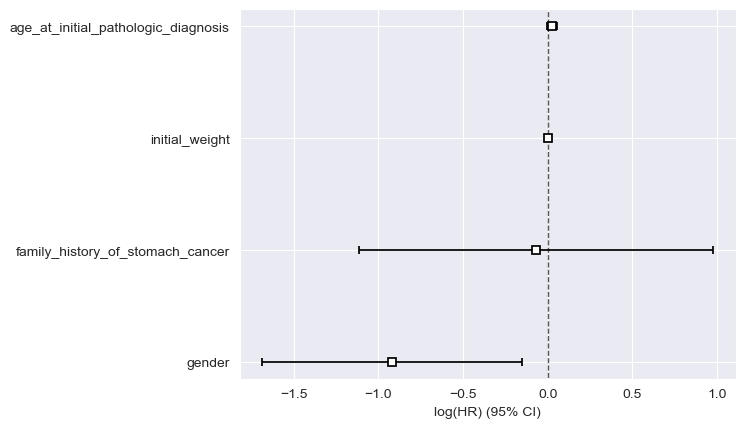

In [54]:
from lifelines import CoxPHFitter

columns = ['DSS.time', 'DSS', 'family_history_of_stomach_cancer', 'initial_weight', 'gender', 'age_at_initial_pathologic_diagnosis']
cph_data = df[columns].dropna(subset=columns, how='any', inplace=False)

# convert to numerical values as needed
cph_data['family_history_of_stomach_cancer'] = cph_data['family_history_of_stomach_cancer'].replace({'NO': 0, 'YES':1})

cph_data['gender'] = cph_data['gender'].replace({'MALE':0, 'FEMALE':1})

cph = CoxPHFitter()
cph.fit(cph_data, duration_col='DSS.time', event_col='DSS')
print(cph.summary)
cph.plot()